# Ai Agent

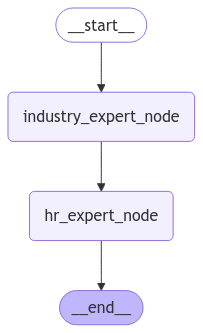

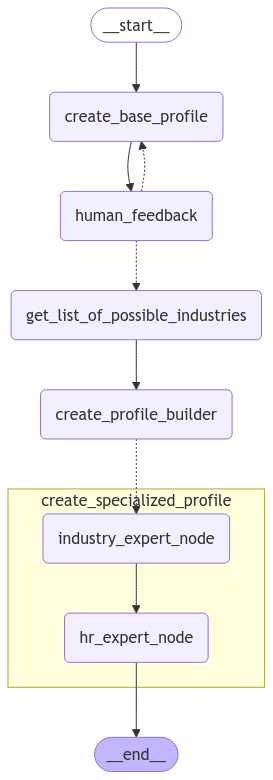

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

# I need to generate an LLm that will create a structured base user profile from the user's CV and cover letter
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
# llm.invoke("Hello, world!")
## Create Profile
### Data formats
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from src.profile_agent.agent_classes import *
from src.profile_agent.agent_functions import *


class UserProfile(BaseModel):
    """
    A class used to represent a user profile
    """
    name: str = Field(
        description="User's name"
    )
    work_experience: str = Field(
        description="User's work experience"
    )
    skills: str = Field(
        description="User's skills"
    )
    education: str = Field(
        description="User's education"
    )
    certifications: str = Field(
        description="User's certifications"
    )
    other_info: str = Field(
        description="Other relevant information"
    )

class UserProfileBuilderAssistant(BaseModel):
    """
    A class used to represent a user profile builder assistant
    """
    name: str = Field(
        description="Name of the analyst."
    )
    industry: str = Field(
        description="The industry of the assistant",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name} \n Specialty: {self.industry}\n Description: {self.description}"
    

class Perspectives(BaseModel):
    """
    A class used to represent the perspectives of the user profile builder assistants
    """
    profile_builder_assistants: List[UserProfileBuilderAssistant] = Field(
        description="List of user profile builder assistants."
    )

class SpecializedProfiles(BaseModel):
    """
    A class used to represent the specialized profiles of the user built by the profile builder assistants
    """
    specialized_profile: List[UserProfile] = Field(
        description="List of specialized user profiles."
    )

class IndustryList(BaseModel):
    """
    A class used to represent a list of industries
    """
    selected_industries: List[str] = Field(
        description="List of industries the person could work in"
    )
### States
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field


class ProfileState(TypedDict):
    """
    A class used to represent the state of the profile generation
    """
    user_docs: List[str]
    user_profile: UserProfile
    specialized_profiles: Annotated[list, operator.add]
    selected_industries: IndustryList
    job_ids: List[str]
    max_industry_experts: int
    user_feedback: str
    profile_builder_assistants: List[UserProfileBuilderAssistant]


### Create user profile from docs
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


def create_base_profile(state: ProfileState) -> dict:
    """
    Creates a summary of the user's profile.

    Args:
    user_docs (List[str]): list of user documents

    Returns:
    str: user profile summary
    """

    system_message = """Your task is to create a detailed user work profile. The user has provided the following documents:
    A CV (please note the content of the CV may be in a strange order due to the format of the document. Please try to reconstruct it in a way that makes sense): 
    {cv}

    A cover letter: 
    {cover_letter}

    Take into consideration the optionally provided user feedback to improve the quality of the generated profile:

    {user_feedback}
    
    Please generate a detailed user profile based on these documents and optional feedback.
    The profile must include the following sections:
    (a) The user's name
    (b) Work experiences
    (c) Skills
    (d) Education
    (e) Certifications
    (f) Other information
    
    Be exhaustive and do not leave any important experience out.
    However, and this is crucial, do not invent anything. 
    If the provided documents and user feedback do not permit you to generate a section, leave it empty.
    I REPEAT: DO NOT INVENT ANY INFORMATION! LEAVE BLANK IF YOU CANNOT ANSWER!

    For example, do not write:
    - Sales Manager at ABC Company
    - Marketing Specialist at XYZ Company
    - Bachelors degree in Computer Science from ABC University
    
    Instead leave it blank.
    """

    system_message = system_message.format(
        cv=state['user_docs'][0],
        cover_letter=state['user_docs'][1], 
        user_feedback=state.get('user_feedback', '')
        )
        
    structured_llm = llm.with_structured_output(UserProfile)
    
    # Update the state with the generated base_profile
    detailed_profile= structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Can you generate the user profile please?")])

    return {"user_profile": detailed_profile}

def human_feedback(state: ProfileState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: ProfileState) -> str:
    """ Return the next node to execute """
    
    # Check if human feedback is present
    human_feedback = state.get('user_feedback', None)
    if human_feedback:
        return "create_base_profile"
    
    # Otherwise continue
    return "get_list_of_possible_industries"
### Create user profile from docs

from src.job_scraping.indentifiers_functions import fetch_industries
def get_list_of_possible_industries(state: ProfileState) -> dict:
    """
    Fetches a list of possible industries for the user profile

    Args:
    state (GenerateProfileState): state of the profile generation

    Returns:
    list: list of possible industries
    """
    all_industries = fetch_industries()
    
    system_message = """Your task is to generate a list of possible industries that the user could work in based on their profile. 
    The user has the following profile:
    {user_profile}

    The possible industries are:
    {all_industries}
    
    Please generate a list of the {max_industry_experts} most likely possible industries that the user could work in.
    """

    system_message = system_message.format(
        user_profile=state.get('user_profile'),
        all_industries=all_industries,
        max_industry_experts=state.get('max_industry_experts')
        )
        
    structured_llm = llm.with_structured_output(IndustryList)
    
    # Update the state with the generated base_profile
    selected_industries= structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Can you generate a list of possible industries for the user profile please?")])

    return {"selected_industries": selected_industries}

def create_profile_builder(state: ProfileState):
    """
    Creates a set of AI assistants to help users build their work profiles.

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    dict: profile builder assistants
    """

    max_industry_experts = state['max_industry_experts']
    user_profile = state['user_profile']
    selected_industries = state['selected_industries']

    #Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    profile_builder_instructions= """You are tasked with creating a set of AI assistants. The purpose of these assistants is to help users build their work profiles. 

        1. First, review the detailed user profile
        {user_profile}

        2. Then review the list of possible industries that the user could work in : {selected_industries}

        3. Based on the user profile and the list of possible industries, create one specialized industry expert for each industry in the list, that is {max_industry_experts} industry experts in total.
        """
    
    
    # System message
    system_message = profile_builder_instructions.format(user_profile=user_profile,
                                                         max_industry_experts=max_industry_experts,
                                                         selected_industries=selected_industries)
    
    # Generate question
    profile_assistant_results = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of profile builder assistants.")])

    # Write the list of assistants to state
    return {"profile_builder_assistants": profile_assistant_results.profile_builder_assistants}
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

# For demonstration, let's assume these come from your environment
# or the same as your tutorial references:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Send
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from typing import TypedDict, List
from typing_extensions import NotRequired
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


class SingleProfileState(TypedDict):
    """
    State used in the subgraph that creates exactly one specialized profile
    for a single industry-expert assistant.
    """
    industry_expert: UserProfileBuilderAssistant
    user_profile: UserProfile
    specialized_profile: str # We'll fill this in
    messages: List  # if you want to store the conversation turn-by-turn

def industry_expert_node(state: SingleProfileState):
    """
   Generates a specialized profile from the perspective of an industry expert.
   Asks an HR expert to review the specialized profile.

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    List: specialized profiles
    """
    # Get state
    industry_expert = state['industry_expert']
    user_profile = state['user_profile']
    specialized_profile = state['specialized_profile']

    # Write system message
    specialized_profile_instructions = """You are an industry expert. 
    Your task is to generate a specialized profile for the user based on the user's detailed profile and the possible industrie that the user could work in.
    You will work together with an HR expert to perfect the profile and make the user stand out in the job market.
    
    The purpose of this profile down the line will be to perform similarity search between this user profile and jobs descriptions. 
    Therefore, it is important that the specialized profile you create be as detailed as possible and contain as many relevant keywords as possible while staying true to the actual profile of the user.
    
    1. First, review your persona: {industry_expert.persona}.
    
    2. Second, review the user profile: {user_profile}.

    3. Third, based on the user profile and the possible industries, generate a specialized profile for the user.
    
    4. Continue to review this profile with the HR expert until it is perfect.

    When you are satisfied with the profile say: "I think we are done!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

    specialized_profile_instructions = specialized_profile_instructions.format(industry_expert=industry_expert, 
                                                                               user_profile=user_profile,
                                                                               specialized_profile=specialized_profile)

    specialized_profile_result = llm.invoke([SystemMessage(content=specialized_profile_instructions)]+[HumanMessage(content="Generate the specialized profile.")])

    if "messages" not in state:
        state["messages"] = []
    state["messages"].append(specialized_profile_result)
    
    return {"specialized_profile": [specialized_profile_result.content]}
def hr_expert_node(state: SingleProfileState):
    """
    Helps the industry expert refine the user profile

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    List: specialized profiles
    """

    # Get state
    industry_expert = state['industry_expert']
    user_profile = state['user_profile']
    specialized_profile = state['specialized_profile']


    help_industry_expert_instructions = """ You are an HR expert with a focus on recruitment and many years of experience in the field.
    Your task is to help the industry expert refine the user profile. 
    
    1. Here is the industry expert's area of focus: {industry_expert.persona}

    2. Here is the user's detailed profile: {user_profile}

    3. Here is the specialized profile they have created: {specialized_profile}
    
    Please refine or improve the specialized profile.
    When you think it's good, say "I think we are done!"
    """

    help_industry_expert_instructions = help_industry_expert_instructions.format(industry_expert=industry_expert, 
                                                                                 user_profile=user_profile, 
                                                                                 specialized_profile=specialized_profile)
    
    revised_profile = llm.invoke([SystemMessage(content=help_industry_expert_instructions)]+[HumanMessage(content="Review the specialized profile.")])

    #revised_profile.name = "hr"

    if "messages" not in state:
        state["messages"] = []
    state["messages"].append(revised_profile)
    
    return {"specialized_profile": [revised_profile.content]}


from langgraph.types import Send

def spawn_specialized_profiles(state: ProfileState):
    """
    This node spawns parallel sub-runs, each calling `single_profile_graph_compiled`.
    """
    industries = state["selected_industries"].selected_industries
    industry_experts = state["profile_builder_assistants"]
    user_profile = state["user_profile"]

    # We'll do a simple zip over them:
    sends = []
    for industry, expert in zip(industries, industry_experts):
        # Create a sub-state for single_profile_graph_compiled
        single_sub_state = {
            "industry_expert": expert,
            "user_profile": user_profile,
            "specialized_profile": "",
            "messages": []
        }
        # We'll spawn a parallel run
        sends.append(Send("create_specialized_profile", single_sub_state))
    return sends

def aggregate_specialized_profiles(substates: List[SingleProfileState]):
    """
    This 'reduce' node merges all specialized profiles from the sub-runs
    into the main parent's `specialized_profiles` list.
    """
    all_profiles = []
    for s in substates:
        # s["specialized_profile"] is the final refined text for that sub-run
        all_profiles.append(s["specialized_profile"])
    return {"specialized_profiles": all_profiles}

single_profile_builder = StateGraph(SingleProfileState)
single_profile_builder.add_node("industry_expert_node", industry_expert_node)
single_profile_builder.add_node("hr_expert_node", hr_expert_node)

single_profile_builder.add_edge(START, "industry_expert_node")
single_profile_builder.add_edge("industry_expert_node", "hr_expert_node")
single_profile_builder.add_edge("hr_expert_node", END)

memory = MemorySaver()
single_profile_graph = single_profile_builder.compile(checkpointer=memory).with_config(run_name="single_profile_graph")

display(Image(single_profile_graph.get_graph().draw_mermaid_png()))
# Add nodes
builder = StateGraph(ProfileState)
builder.add_node("create_base_profile", create_base_profile)
builder.add_node("human_feedback", human_feedback)
builder.add_node("get_list_of_possible_industries", get_list_of_possible_industries)
builder.add_node("create_profile_builder", create_profile_builder)
builder.add_node("create_specialized_profile", single_profile_builder.compile())  # <-- rename
#builder.add_node("aggregate_specialized_profiles", aggregate_specialized_profiles)

# Graph flow
builder.add_edge(START, "create_base_profile")
builder.add_edge("create_base_profile", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_base_profile", "get_list_of_possible_industries"])
builder.add_edge("get_list_of_possible_industries", "create_profile_builder")
builder.add_conditional_edges("create_profile_builder", spawn_specialized_profiles, ["create_specialized_profile"])
#builder.add_edge("create_specialized_profile", "aggregate_specialized_profiles")
builder.add_edge("create_specialized_profile", END)


# Compile
memory = MemorySaver()
graph = builder.compile(#interrupt_before=["human_feedback"], 
                        checkpointer=memory)

# view
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
from src.data_processing.process_documents import process_cv, process_cover_letter

file_paths = [r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CV_2024.pdf", r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CoverLetter.pdf"]
thread = {"configurable": {"thread_id": "1"}}

test_state = ProfileState(
    user_docs=[process_cv(file_paths[0]), process_cover_letter(file_paths[1])],
    max_industry_experts=1,
    human_feedback=None
    )


final_state = graph.invoke(test_state, thread)

In [2]:
final_state

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre